Import Packages

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
import operator

Files for Gephi

In [2]:
df = pd.read_csv(r'./dataset.csv')

df2 = df[["track_id","writers","track_name","track_pos"]]
df2_dict = df2.to_dict(orient='records')

d = []

for f in df2_dict:
    d.extend(f["writers"].split("-"))

set_d = set([a.strip() for a in d])
dict_vett_writers = []
new_dict_vect_writers = []
support = []
support2 = ""

for writer in set_d:
    for d in df2_dict:
        if writer in [a.strip() for a in d["writers"].split("-")]:
            support.append({"name":d["track_name"],"pos":d["track_pos"], "year": int(d["track_id"].split("_")[0])})
            support2 += d["track_name"]+" - "+str(d["track_pos"])+ " - " + str(d["track_id"].split("_")[0]) + ","
    dict_vett_writers.append({"writer":writer,"tracks":support})
    new_dict_vect_writers.append({"writer":writer,"tracks":support2[:-1].split(",")})
    support = []
list_edges = []
l_e_new = []
list_weights = []

for dic in dict_vett_writers:
    for dic2 in dict_vett_writers:
        for song in dic["tracks"]:
            if song in dic2["tracks"] and dic["writer"] != dic2["writer"]:
                if {"source":dic["writer"],"target":dic2["writer"]} in list_edges:
                    index = list_edges.index({"source":dic["writer"],"target":dic2["writer"]})
                    list_weights[index] += (10-song["pos"])
                else:
                    common_tracks =[]
                    list_edges.append({"source":dic["writer"],"target":dic2["writer"]})
                    for t1 in dic["tracks"]:
                        if t1 in dic2["tracks"]:
                            common_tracks.append(t1)
                    l_e_new.append({"source":dic["writer"],"target":dic2["writer"],"tracks":common_tracks, "year": t1["year"]})
                    list_weights.append(1 + (10-song["pos"]))

for weight in list_edges:
    a = weight["source"]
    b = weight["target"]
    index = list_edges.index(weight)
    try:
        list_edges.remove({"source":b,"target":a})
        list_weights.remove(list_weights[index])
    except:
        pass

lista =list(set([str(a["writer"]).strip() for a in dict_vett_writers]))
print(True if ("M. Vicino") in lista else False)
'''for w in lista:
    if w not in [b["source"] for b in list_edges]:
        lista.remove(w)'''

True


'for w in lista:\n    if w not in [b["source"] for b in list_edges]:\n        lista.remove(w)'

In [3]:
#top songwriters per numero di canzoni
v_singers = ['D. Pace','F. Migliacci','M. Panzeri','Mogol','A. Cogliati']
tabella = []
for singer in v_singers:
    val_singer = 0
    val_placed = 0
    for i , row in df2.iterrows():
        if singer in [a.strip() for a in row["writers"].split("-")] and row["track_pos"] <= 1:
            val_singer += 1
        if singer in [a.strip() for a in row["writers"].split("-")]:
            val_placed += 1
    tabella.append({"writer":singer,"val_top3":val_singer, "val_placed":val_placed})
    print("fine "+singer)

print(tabella)

fine D. Pace
fine F. Migliacci
fine M. Panzeri
fine Mogol
fine A. Cogliati
[{'writer': 'D. Pace', 'val_top3': 0, 'val_placed': 22}, {'writer': 'F. Migliacci', 'val_top3': 3, 'val_placed': 15}, {'writer': 'M. Panzeri', 'val_top3': 2, 'val_placed': 26}, {'writer': 'Mogol', 'val_top3': 4, 'val_placed': 16}, {'writer': 'A. Cogliati', 'val_top3': 2, 'val_placed': 11}]


In [4]:
v_singers = list(set([a["writer"] for a in dict_vett_writers]))
tabella = []
tabella2 = []
for singer in v_singers:
    val_singer = 0
    val_placed = 0
    for i , row in df2.iterrows():
        if singer in [a.strip() for a in row["writers"].split("-")] and row["track_pos"] <= 1:
            val_singer += 1
        if singer in [a.strip() for a in row["writers"].split("-")]:
            val_placed += 1
    if val_placed > 0 and val_singer > 1:
        tabella.append({"writer":singer,"val_agg":val_singer/val_placed , "val_top3":val_singer, "val_number":val_placed})
    #print("fine "+singer)

for singer in v_singers:
    val_singer = 0
    val_placed = 0
    for i , row in df2.iterrows():
        if singer in [a.strip() for a in row["writers"].split("-")] and row["track_pos"] <= 1:
            val_singer += 1
        if singer in [a.strip() for a in row["writers"].split("-")]:
            val_placed += 1
    tabella2.append({"writer":singer,"val_agg":val_singer/val_placed , "val_top3":val_singer, "val_number":val_placed})


print(tabella)
print(len(tabella))

[{'writer': 'M. Falagiani', 'val_agg': 0.4, 'val_top3': 2, 'val_number': 5}, {'writer': 'S. Bardotti', 'val_agg': 0.3333333333333333, 'val_top3': 2, 'val_number': 6}, {'writer': 'M. Panzeri', 'val_agg': 0.07692307692307693, 'val_top3': 2, 'val_number': 26}, {'writer': 'A. Testa', 'val_agg': 0.18181818181818182, 'val_top3': 2, 'val_number': 11}, {'writer': 'C. Minellono', 'val_agg': 0.25, 'val_top3': 2, 'val_number': 8}, {'writer': 'D. Farina', 'val_agg': 0.3333333333333333, 'val_top3': 2, 'val_number': 6}, {'writer': 'G. Fiorelli', 'val_agg': 0.5, 'val_top3': 2, 'val_number': 4}, {'writer': 'E. Ramazzotti', 'val_agg': 0.6, 'val_top3': 3, 'val_number': 5}, {'writer': 'G. Golzi', 'val_agg': 0.3333333333333333, 'val_top3': 2, 'val_number': 6}, {'writer': 'P. Cassano', 'val_agg': 0.25, 'val_top3': 3, 'val_number': 12}, {'writer': 'F. Migliacci', 'val_agg': 0.2, 'val_top3': 3, 'val_number': 15}, {'writer': 'Mogol', 'val_agg': 0.25, 'val_top3': 4, 'val_number': 16}, {'writer': 'M. Luca', 'va

In [5]:
aaa = sorted(tabella, key=lambda k: float(k['val_agg']), reverse=True)
bbb = sorted(tabella2, key=lambda k: float(k['val_agg']), reverse=True)
v_singers = ['D. Pace','F. Migliacci','M. Panzeri','Mogol','A. Cogliati']
print(aaa)
for s in v_singers:
    try:
        print(s,"  ", [a['writer']for a in aaa].index(s))
    except:
        print(s,"  ", "not found")

print("------------------")
for s in v_singers:
    try:
        print(s,"  ", aaa[[a['writer']for a in aaa].index(s)]["val_number"])
    except:
        print(s,"  ", bbb[[b['writer']for b in bbb].index(s)]["val_number"])

[{'writer': 'M. Luca', 'val_agg': 1.0, 'val_top3': 2, 'val_number': 2}, {'writer': 'P. Palma', 'val_agg': 1.0, 'val_top3': 2, 'val_number': 2}, {'writer': 'F. Gabbani', 'val_agg': 1.0, 'val_top3': 2, 'val_number': 2}, {'writer': 'F. Ilacqua', 'val_agg': 1.0, 'val_top3': 2, 'val_number': 2}, {'writer': 'D. Verde', 'val_agg': 1.0, 'val_top3': 2, 'val_number': 2}, {'writer': 'E. Ramazzotti', 'val_agg': 0.6, 'val_top3': 3, 'val_number': 5}, {'writer': 'G. Fiorelli', 'val_agg': 0.5, 'val_top3': 2, 'val_number': 4}, {'writer': 'A. Salerno', 'val_agg': 0.5, 'val_top3': 4, 'val_number': 8}, {'writer': 'D. Modugno', 'val_agg': 0.5, 'val_top3': 4, 'val_number': 8}, {'writer': 'M. Falagiani', 'val_agg': 0.4, 'val_top3': 2, 'val_number': 5}, {'writer': 'M. Masini', 'val_agg': 0.4, 'val_top3': 2, 'val_number': 5}, {'writer': 'M. Ruccione', 'val_agg': 0.4, 'val_top3': 2, 'val_number': 5}, {'writer': 'L. Chiaravalli', 'val_agg': 0.4, 'val_top3': 2, 'val_number': 5}, {'writer': 'G. Dati', 'val_agg': 0

Creation of the files

In [6]:
writers = open("artisti.csv","w")
writers.write("Id,Label\n")
writers.write('\n'.join([str(a) + "," + str(a) for a in lista]))#('\n'.join(lista))
writers.close()

writersTracks = open("artisti_e_canzoni.csv","w")
writersTracks.write("Writer,Songs\n")
writersTracks.write('\n'.join([str(a["writer"]) + "," + str(a["tracks"]) for a in dict_vett_writers]))
writersTracks.close()

outfile = open("edges_list.csv","w")
outfile.write("Source,Target,Weight\n")
outfile.write('\n'.join([str(list_edges[i]["source"]) + "," + str(list_edges[i]["target"]) +","+ str(list_weights[i]) for i in range( len(list_edges))]))
outfile.close()

In [7]:
G = nx.Graph()
G.add_nodes_from(lista)
ebunch = [(list_edges[i]["source"],list_edges[i]["target"],{"weight":list_weights[i]}) for i in range( len(list_edges))]
G.add_edges_from(ebunch)

'''gMogol = nx.Graph()
gMogol.add_nodes_from(lista)
ebunchMogol = [(list_edges[i]["source"],list_edges[i]["target"],{"weight":list_weights[i]}) for i in range( len(list_edges)) if list_edges[i]["source"] == "Mogol" or list_edges[i]["target"] == "Mogol"]
gMogol.add_edges_from(ebunchMogol)
gMogol.remove_nodes_from(list(nx.isolates(gMogol)))'''

#degree centrality
print("degree centrality")
deg_centrality = nx.degree_centrality(G)
#nx.write_gexf(deg_centrality, "deg_cent.gexf")
print(deg_centrality,'\n')

'''import collections
from scipy.interpolate import make_interp_spline
#degree distribution
print("degree distribution")
print(nx.degree_histogram(G),'\n') #find probability
#plot degree distribution as a bar plot with a spline on top of the same data points
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
x = range(len(nx.degree_histogram(G)))
y = nx.degree_histogram(G)
xnew = np.linspace(min(x), max(x), 300)
spl = make_interp_spline(x, y, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.bar(deg, cnt, width=0.80, color="b")
plt.plot(xnew, power_smooth, color="red")   
plt.title("Degree Distribution Graph")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()'''


'''
plt.plot(xnew, power_smooth, color="red")
plt.show()'''



#pagerank
print("pagerank")
prank=nx.pagerank(G, weight="weight")
print(prank,'\n')

#average clustering coefficient
print("average clustering coefficient")
print(nx.average_clustering(G,weight="weight"),'\n')



#k-cliques
cliqueMatrix = []
cliqueMatrix.append([])
cliqueMatrix.append([])
for k in range(2,8):
    i = 0
    cliqueMatrix.append([])
    for clique in nx.find_cliques(G):
        if len(clique) == k:
            i += 1
            cliqueMatrix[k].append(clique)
        '''elif len(clique) > k:
            i += len(list(itertools.combinations(clique, k)))'''
    print(k,"-clique: ", i)
print('\n')

#clique edges experimental
def travel_list(l,k):
    for el in l:
        a = el.get(k,None)
        if a == None:
            continue
        else:
            return a

cliqueEdges= []
target = [{str(a["source"] + a["target"]):{"s":a["source"],"d":a["target"],"tracks":','.join([f["name"] + " - " + str(f["pos"]) + " - " + str(a["year"]) for f in a["tracks"]])}} for a in l_e_new]
#print("target - ", target)
for i in range(len(cliqueMatrix[6])):
    cliqueEdges.append([])
    for node1 in cliqueMatrix[6][i]:
        s = []
        for node2 in cliqueMatrix[6][i]:
            t = travel_list(target,str(node1 + node2))
            if not t in s and t is not None:
                s.append(t)
        cliqueEdges.append(list(s))

result = [c for c in cliqueEdges ]#if len(c)>1]
#print("RES - ", result)

#############################
#find how many songs in every clique
for k in range(2,8):
    cliqueSongs = []
    songyears = 0
    songmin = 2020
    songmax = 1950
    c=0
    for i in range(len(cliqueMatrix[k])):
        songs = []
        append_this = []
        for artist in cliqueMatrix[k][i]:
            for d in dict_vett_writers:
                if d["writer"] == artist:
                    for song in d["tracks"]:
                        songs.append(song["name"] +" - " +str(song["pos"]) + " - " + str(song["year"]))
                        songyears += song["year"]
                        if song["year"] < songmin:
                            songmin = song["year"]
                        if song["year"] > songmax:
                            songmax = song["year"]
                        c +=1
            songs_set = set(songs)
            append_this = [[s,0] for s in songs_set]
            for song in songs:
                for j in range(len(append_this)):
                    if song == append_this[j][0]:
                        append_this[j][1] += 1 #(song,append_this[j][1]+1)
            append_this = [a[0] for a in append_this if a[1] > 1]

        cliqueSongs.append("Clique number " + str(i) + " - " + str(append_this))
    mediayears = songyears/c
    '''print("clique songs - ", cliqueSongs , " k = ", k)
    print("anno medio - ", mediayears, " anno minimo - ", songmin, " anno massimo - ", songmax, " k = ", k)'''


#create subgraph with all nodes and edges connected to node "D. Pace"
list_nodes_connected = list(nx.node_connected_component(G, "D. Pace"))



#Degree Centrality, Degree Distibution, PageRank, Local Clustering Coefficient, N-cliques, Closeness, Betweenness

degree centrality
{'A. Valsiglio': 0.012195121951219513, 'D. Gambi': 0.0020325203252032522, 'A. Zuccaro': 0.006097560975609756, 'S. Piro': 0.0, 'M. Falagiani': 0.003048780487804878, 'G. Belleno': 0.0020325203252032522, 'D. Miglietta': 0.003048780487804878, 'S. Basile': 0.0, 'G. Mangiaracina': 0.0020325203252032522, 'O. Prudente': 0.0020325203252032522, 'R. Cellamare': 0.007113821138211383, 'G. Argenio': 0.0040650406504065045, 'N. Zilli': 0.0020325203252032522, 'G. C. Testoni': 0.006097560975609756, 'C. Lo Mele': 0.005081300813008131, 'S. Borgia': 0.0010162601626016261, 'R. Righini': 0.0010162601626016261, 'V. Stein': 0.0020325203252032522, 'P. Jannacci': 0.0020325203252032522, 'S. Iodice': 0.0040650406504065045, 'F. Arnò': 0.0020325203252032522, 'Malise': 0.0020325203252032522, 'V. Mascheroni': 0.005081300813008131, 'G. Castellani': 0.0020325203252032522, 'J. Monasta': 0.003048780487804878, 'La Valle': 0.0020325203252032522, 'G. Faiella': 0.005081300813008131, 'L. Mattioni': 0.00304878

KeyboardInterrupt: 

[92, 246, 273, 132, 100, 64, 25, 15, 12, 5, 3, 4, 3, 3, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1] 

[0.09340101522842639, 0.24974619289340103, 0.27715736040609135, 0.13401015228426397, 0.10152284263959391, 0.0649746192893401, 0.025380710659898477, 0.015228426395939087, 0.012182741116751269, 0.005076142131979695, 0.003045685279187817, 0.0040609137055837565, 0.003045685279187817, 0.003045685279187817, 0.0010152284263959391, 0.0020304568527918783, 0.0010152284263959391, 0.0, 0.0010152284263959391, 0.0, 0.0010152284263959391, 0.0010152284263959391, 0.0, 0.0, 0.0, 0.0, 0.0010152284263959391]


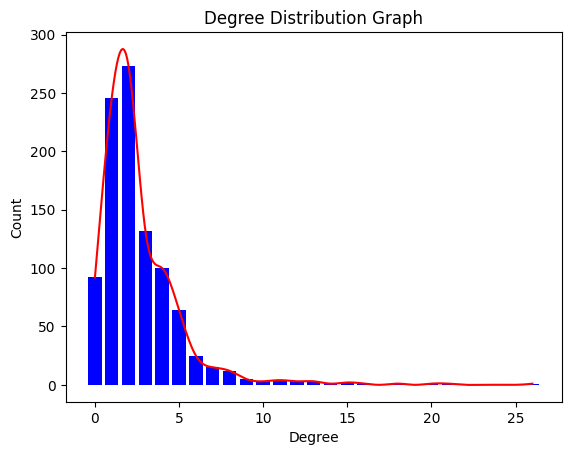

[983, 891, 645, 372, 240, 140, 76, 51, 36, 24, 19, 16, 12, 9, 6, 5, 3, 2, 2, 1, 1]
[1.0, 0.9064089521871821, 0.6561546286876907, 0.37843336724313326, 0.2441505595116989, 0.14242115971515767, 0.07731434384537131, 0.05188199389623601, 0.03662258392675483, 0.024415055951169887, 0.019328585961342827, 0.01627670396744659, 0.012207527975584944, 0.009155645981688708, 0.006103763987792472, 0.00508646998982706, 0.003051881993896236, 0.002034587995930824, 0.002034587995930824, 0.001017293997965412, 0.001017293997965412]


In [48]:
#cumulative distribution function
# print("cumulative distribution function")
import collections
from scipy.interpolate import make_interp_spline

print(nx.degree_histogram(G),'\n') #find probability
d_hist_list = nx.degree_histogram(G)
#divide each element by the number of nodes in G
d_hist_list = [float(i)/nx.number_of_nodes(G) for i in d_hist_list]
print(d_hist_list)



degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
x = range(len(nx.degree_histogram(G)))
y = nx.degree_histogram(G)
xnew = np.linspace(min(x), max(x), 300)
spl = make_interp_spline(x, y, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.bar(deg, cnt, width=0.80, color="b")
plt.plot(xnew, power_smooth, color="red")
plt.title("Degree Distribution Graph")
plt.ylabel("Count")

plt.xlabel("Degree")
plt.show()

#print(degreeCount)
pd = []
for i in range(0,len(degreeCount)):
    sum_deg = 0
    for j in range(i,len(degreeCount)):
        sum_deg += degreeCount[j]
    pd.append(sum_deg)

print(pd)
percentages = [float(i)/pd[0] for i in pd]
print(percentages)  


Funzione Commutativa: [1.         0.72452408 0.41881299 0.27099664 0.15901456 0.08734602
 0.0593505  0.04255319 0.02911534 0.02351624 0.02015677 0.01567749
 0.01231803 0.00895857 0.00783875 0.0055991  0.00447928 0.00447928
 0.00335946 0.00335946 0.00223964 0.00111982 0.00111982 0.00111982
 0.00111982 0.00111982]
Indice di Scala (Esponente di Scala): 2.4440800470173496


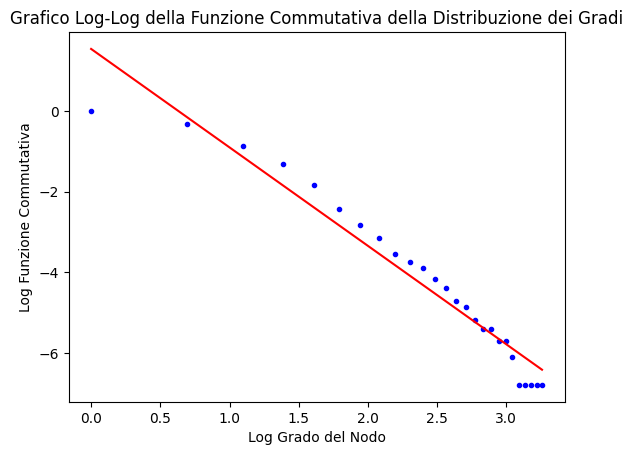

In [56]:


# Calcola la distribuzione dei gradi
degree_sequence = [d for n, d in G.degree() if d > 0]

# Calcola la distribuzione normalizzata dei gradi
degree_count = np.bincount(degree_sequence)
degree_prob = degree_count / degree_count.sum()
#remove zero values
#degree_prob = [a for a in degree_prob if a != 0]

# Calcola la funzione commutativa della distribuzione
commutative_dist = 1 - np.cumsum(degree_prob)
commutative_dist = commutative_dist[:-1]
print("Funzione Commutativa:", commutative_dist)



'''# Escludi i valori con probabilità 0
non_zero_indices = degree_prob.nonzero()
degree_prob_non_zero = degree_prob[non_zero_indices]'''

# Calcola l'indice di scala (esponente di scala) utilizzando il fit lineare sulla funzione commutativa
log_degrees = np.log(np.arange(1, len(commutative_dist) + 1))
log_commutative = np.log(commutative_dist)
slope, intercept = np.polyfit(log_degrees, log_commutative, 1)
scale_exponent = -slope

print("Indice di Scala (Esponente di Scala):", scale_exponent)

# Visualizza il grafico log-log della funzione commutativa
plt.scatter(log_degrees, log_commutative, color='blue', marker='.')
plt.plot(log_degrees, slope * log_degrees + intercept, color='red')
plt.xlabel('Degree (log)')
plt.ylabel('Commutative Distribution (log)')
plt.title('Log-Log Commutative Distribution')
plt.show()

In [ ]:
target = local_clustering
title = "Local Clustering Coefficient"

#ONLY CHANGE THINGS ABOVE THIS LINE

to_graph = {k: v for k, v in sorted(target.items(), key=lambda item: item[1], reverse=True)}
to_graph = [[k,v] for k,v in to_graph.items()][:10]
#print bar graph of closeness centrality

species = ('Adelie', 'Chinstrap', 'Gentoo')
sex_counts = {v[0]:v[1] for v in to_graph}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(len(to_graph))

for name, value in sex_counts.items():
    p = ax.bar(name, value, width, label=value)
    #bottom += value

    ax.bar_label(p, label_type='center')

ax.set_title(title)
#ax.legend()

plt.show()

NameError: name 'local_clustering' is not defined

In [ ]:
# sort by degree centrality
sorted_deg_centrality = sorted(deg_centrality.items(), key=operator.itemgetter(1), reverse=True)
print("sorted degree centrality")
print(sorted_deg_centrality[:5],'\n')

# sort by degree centrality
sorted_pagerank = sorted(nx.pagerank(G, weight="weight").items(), key=operator.itemgetter(1), reverse=True)
print("sorted pagerank")
print(sorted_pagerank[:5],'\n')

sorted degree centrality
[('D. Pace', 0.026422764227642278), ('F. Migliacci', 0.021341463414634148), ('M. Panzeri', 0.020325203252032523), ('Mogol', 0.01829268292682927), ('A. Cogliati', 0.016260162601626018)] 

sorted pagerank
[('D. Pace', 0.0069268064666892), ('F. Migliacci', 0.006009808228256746), ('Mogol', 0.00550693661210509), ('M. Panzeri', 0.004919920629603301), ('G. Bigazzi', 0.0048783108674058375)] 



In [ ]:
newfile = open("ce.txt","w")
newfile.write('\n'.join([str(b["s"]) + " | " + str(b["d"]) + " | " + str(b["tracks"]) for a in result for b in a])) 
newfile.close()

newfile2 = open("deg_centrality.csv","w")
newfile2.write("Writer,Label,Degree Centrality\n")
newfile2.write('\n'.join([str(a) + ","+ str(a) +"," + str(deg_centrality[a]) for a in deg_centrality]))
newfile2.close()

nx.write_gexf(gMogol, "mogol.gexf")
